In [1]:
from keras import layers,losses
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.math import reduce_prod
import matplotlib.pyplot as plt 
import cv2
import os
import numpy as np
import pickle

2024-02-22 17:41:01.148614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 17:41:01.217451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 17:41:01.218902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 17:41:02.758465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Load training set images
train_images=[]
train_image_names=[]

for file_name in os.listdir('./DataBase'):
    train_images.append(cv2.imread('./DataBase/'+file_name,2))
    train_image_names.append(file_name)

train_images = np.asarray(train_images,dtype=np.float32)/255

In [3]:
#Load test set images
test_images=[]
test_image_names=[]

for file_name in os.listdir('./test'):
    test_images.append(cv2.imread('./test/'+file_name,2))
    test_image_names.append(file_name)

test_images = np.asarray(test_images,dtype=np.float32)/255

In [74]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim*2, activation='relu'),
      layers.Dense(latent_dim, activation='selu'),
    ])
    self.decoder = Sequential([
      layers.Dense(latent_dim*2, activation='selu'),
      layers.Dense(reduce_prod(shape), activation='relu'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [75]:
shape = train_images.shape[1:]

autoencoder_100 = Autoencoder(100, shape)
autoencoder_50 = Autoencoder(50, shape)
autoencoder_10 = Autoencoder(10,shape)

autoencoder_100.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_50.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_10.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [76]:
#Create model checkpoints to save the models

save_callback_100 = ModelCheckpoint(filepath='./models/autoencoder_nonlin_100', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

save_callback_50 = ModelCheckpoint(filepath='./models/autoencoder_nonlin_50', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

save_callback_10 = ModelCheckpoint(filepath='./models/autoencoder_nonlin_10', save_weights_only=False,
                                    monitor='val_loss', 
                                    mode='min', save_best_only=True)

In [ ]:
autoencoder_100.fit(train_images, train_images,
                epochs=400,
                shuffle=True,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_100], use_multiprocessing=True)


In [ ]:
autoencoder_50.fit(train_images, train_images,
                epochs=400,
                shuffle=True,
                verbose=1,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_50], use_multiprocessing=True)

In [ ]:
autoencoder_10.fit(train_images, train_images,
                epochs=800,
                shuffle=True,
                verbose=1,
                validation_data=(test_images, test_images), 
                callbacks=[save_callback_10], use_multiprocessing=True)

In [5]:
#Load saved models

autoencoder_100 = load_model('./models/autoencoder_nonlin_100')
autoencoder_50 = load_model('./models/autoencoder_nonlin_50')
autoencoder_10 = load_model('./models/autoencoder_nonlin_10')

2024-02-22 17:41:23.763799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 17:41:23.861678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
def successful_retrieval(test, test_names, train, train_names):
    success_rate=0

    for i, test_img in enumerate(test):

        mean_diff = [np.mean((train_img-test_img)**2)for train_img in train]
        
        if test_names[i] == train_names[np.argmin(mean_diff)]:
            success_rate+=1

    return success_rate

In [12]:
enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_100.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_100.encoder(np.asarray([img])))


result_100 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (100 latent_dim): " + str(result_100) +"/10")

enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_50.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_50.encoder(np.asarray([img])))


result_50 = successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (50 latent_dim): " + str(result_50) +"/10")


enc_train_imgs=[]

for img in train_images:
   enc_train_imgs.append(autoencoder_10.encoder(np.asarray([img])))

enc_test_imgs=[]

for img in test_images:
   enc_test_imgs.append(autoencoder_10.encoder(np.asarray([img])))


result_10= successful_retrieval(enc_test_imgs,test_image_names,enc_train_imgs, train_image_names)


print("=========================================================")
print("AE (10 latent_dim): " + str(result_10) +"/10")

AE (100 latent_dim): 7/10
AE (50 latent_dim): 6/10
AE (10 latent_dim): 4/10


In [13]:
with open('./results/ae_non_linear_100', 'wb') as output:
    pickle.dump(result_100, output)

with open('./results/ae_non_linear_50', 'wb') as output:
    pickle.dump(result_50, output)

with open('./results/ae_non_linear_10', 'wb') as output:
    pickle.dump(result_10, output)

In [6]:
#Pass the test images through the autoencoders and get the results

encoded_imgs = autoencoder_100.encoder(test_images)
test_imgs_100 = autoencoder_100.decoder(encoded_imgs)


encoded_imgs = autoencoder_50.encoder(test_images)
test_imgs_50 = autoencoder_50.decoder(encoded_imgs)

encoded_imgs = autoencoder_10.encoder(test_images)
test_imgs_10 = autoencoder_10.decoder(encoded_imgs)

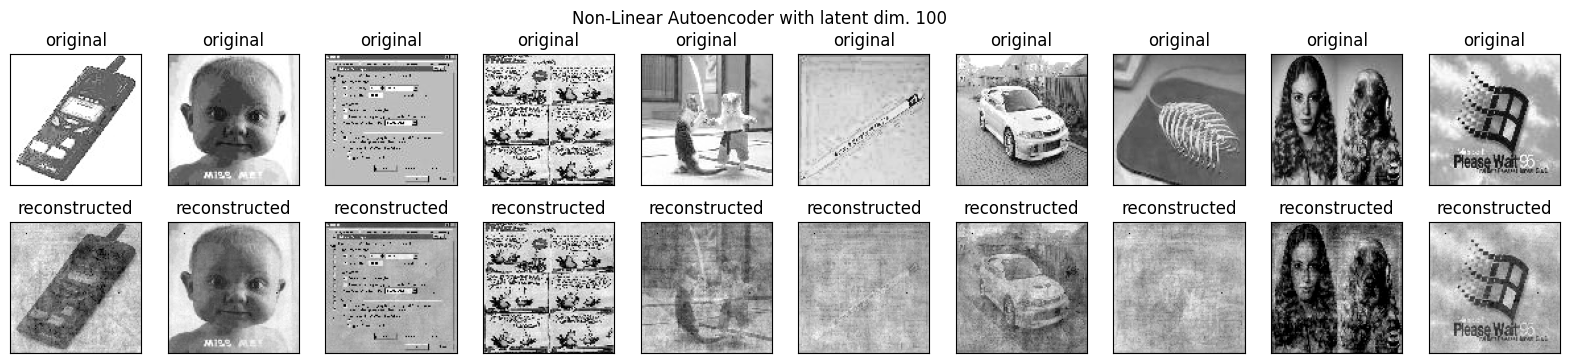

In [7]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Non-Linear Autoencoder with latent dim. 100")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_100[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig('./images/ae_nonlin_100.png')
plt.show()

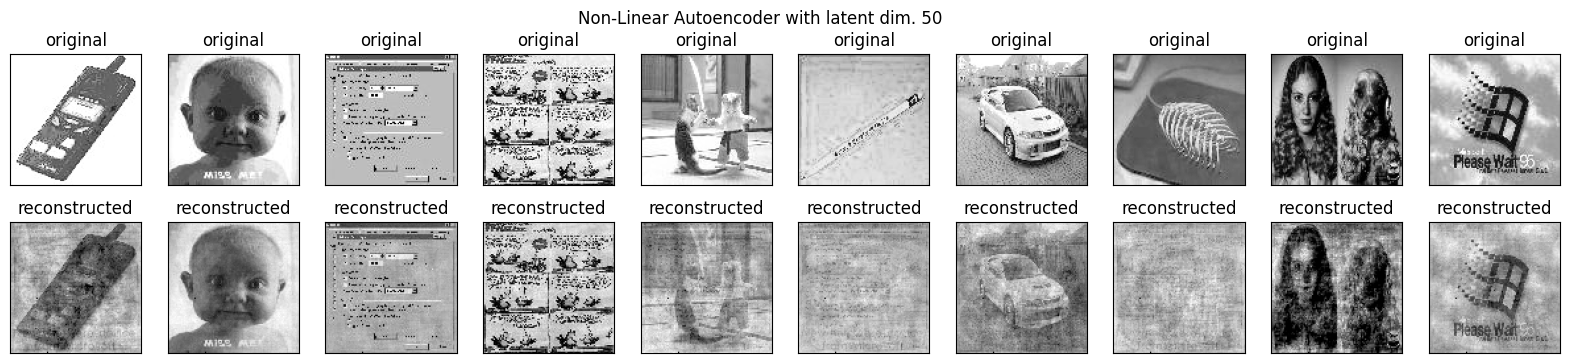

In [8]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Non-Linear Autoencoder with latent dim. 50")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_50[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('./images/ae_nonlin_50.png')
plt.show()

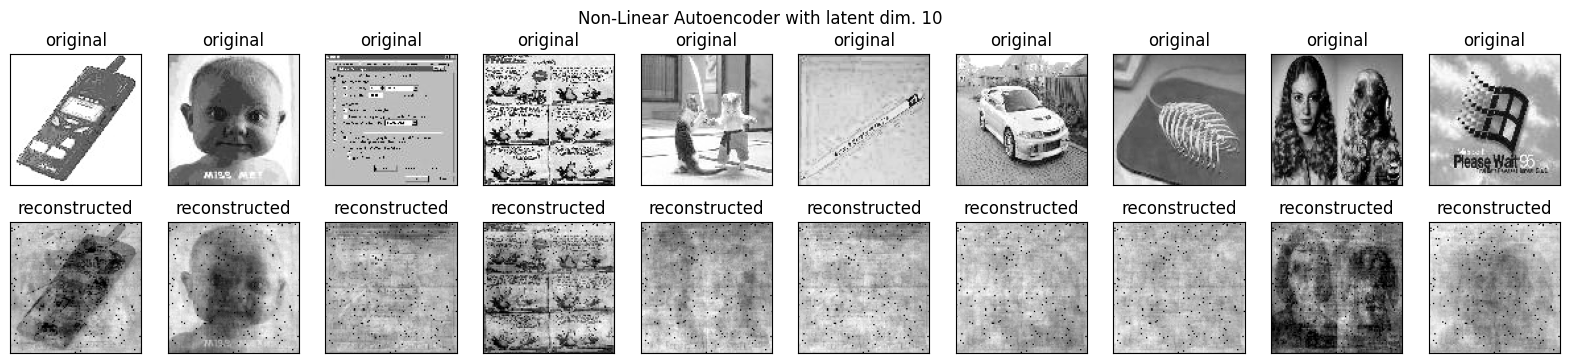

In [9]:
n = 10
fig = plt.figure(figsize=(20, 4))
fig.suptitle("Non-Linear Autoencoder with latent dim. 10")
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_imgs_10[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('./images/ae_nonlin_10.png')
plt.show()